In [1]:
import string
from nltk.corpus import stopwords
from pymystem3 import Mystem
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

CORPUS_PATH = 'corpus.csv'

In [2]:
# Инициализация данных
df = pd.DataFrame()
df[['Number', 'Title', 'Reestr_main', 'Reestr_detail', 'Mark', 'Description']] = pd.read_csv(CORPUS_PATH, sep=';')[
    [u'Номер', u'Тема', u'Реестр (папка)', u'Реестр (детализация)', u'Метка', u'Описание']
]
# Удаляем пустые строки
df['Description'] = df['Description'].fillna(' ')
# Объединяем сообщения из одного обращения 
aggregation_functions = {'Title': 'first', 'Reestr_main': 'first', 'Reestr_detail': 'first', 'Mark': 'first',
                         'Description': ' '.join}
df_new = df.groupby('Number', as_index=False).aggregate(aggregation_functions)
df_new['Content'] = df_new.Title + ' ' + df_new.Reestr_main + ' ' + df_new.Reestr_detail + ' ' + df_new.Description
df_new

,Number,Title,Reestr_main,Reestr_detail,Mark,Description,Content
0,601919,Заполнение раздела 9.1. финансовое обеспечение,Паспорта проектов,Региональные проекты (Общие положения),УНП. ФО РП/ФП/НП,В паспорте РП «Обеспечение устойчивого сокраще...,Заполнение раздела 9.1. финансовое обеспечение...
1,635226,"Необходимо применить ЗИ РП "" A1-51-2019/002"" ...",Паспорта проектов,Региональные проекты (Общие положения),УНП. ЗНИ ФП/НП/РП. Ошибки применения,"Необходимо применить ЗИ РП "" A1-51-2019/002"" ...","Необходимо применить ЗИ РП "" A1-51-2019/002"" ..."
2,653981,Применить ЗИ РП,Паспорта проектов,Региональные проекты (Общие положения),УНП. ЗНИ ФП/НП/РП. Ошибки применения,Уважаемый пользователь!<br/><br/>Запрос примен...,Применить ЗИ РП Паспорта проектов Региональные...
3,656117,Чистая вода (Курская область),Паспорта проектов,Региональные проекты (Общие положения),УНП. ЗНИ ФП/НП/РП. Ошибки применения,Уважаемый Пользователь!<br/><br/>Ваша заявка п...,Чистая вода (Курская область) Паспорта проекто...
4,661599,Сохранение лесов (Республика Тыва),Паспорта проектов,Региональные проекты (Общие положения),УНП. ФО РП/ФП/НП,Уважаемый Пользователь!<br/><br/>Ваша заявка п...,Сохранение лесов (Республика Тыва) Паспорта пр...
...,...,...,...,...,...,...,...
1033,974532,Внесение изм в РП Современная школа,Запросы на изменение проектов,Запрос на изменение (Региональные проекты),УНП. ФО РП/ФП/НП,Номер документа / код КБК: Е 1<br/>Описание пр...,Внесение изм в РП Современная школа Запросы на...
1034,974600,09.янв,Паспорт проекта (Региональные проекты),Региональные проекты (Периодический мониторинг),УНП. Периодический мониторинг. В 9.1 не отража...,Номер документа / код КБК:<br/>Описание пробле...,09.янв Паспорт проекта (Региональные проекты) ...
1035,974601,Статусы исполнения КТ,Паспорт проекта (Региональные проекты),Региональные проекты (Периодический мониторинг),УНП. Периодический мониторинг. В 9.1 не отража...,Номер документа / код КБК:<br/>Описание пробле...,Статусы исполнения КТ Паспорт проекта (Региона...
1036,974619,Подтягивается КТ 2019 года на январь 2020. Рез...,Паспорт проекта (Региональные проекты),Региональные проекты (Периодический мониторинг),УНП. Периодический мониторинг. Ошибки при отпр...,Номер документа / код КБК:<br/>Описание пробле...,Подтягивается КТ 2019 года на январь 2020. Рез...


In [3]:
# Формируем новый датасет с 3 колонками
df1 = df_new[['Mark', 'Content']].copy()
df1

,Mark,Content
0,УНП. ФО РП/ФП/НП,Заполнение раздела 9.1. финансовое обеспечение...
1,УНП. ЗНИ ФП/НП/РП. Ошибки применения,"Необходимо применить ЗИ РП "" A1-51-2019/002"" ..."
2,УНП. ЗНИ ФП/НП/РП. Ошибки применения,Применить ЗИ РП Паспорта проектов Региональные...
3,УНП. ЗНИ ФП/НП/РП. Ошибки применения,Чистая вода (Курская область) Паспорта проекто...
4,УНП. ФО РП/ФП/НП,Сохранение лесов (Республика Тыва) Паспорта пр...
...,...,...
1033,УНП. ФО РП/ФП/НП,Внесение изм в РП Современная школа Запросы на...
1034,УНП. Периодический мониторинг. В 9.1 не отража...,09.янв Паспорт проекта (Региональные проекты) ...
1035,УНП. Периодический мониторинг. В 9.1 не отража...,Статусы исполнения КТ Паспорт проекта (Региона...
1036,УНП. Периодический мониторинг. Ошибки при отпр...,Подтягивается КТ 2019 года на январь 2020. Рез...


In [4]:
# Выводим все метки
pd.DataFrame(df.Mark.unique()).values

array([['УНП. ФО РП/ФП/НП'],
       ['УНП. ЗНИ ФП/НП/РП. Ошибки применения'],
       ['УНП. Периодический мониторинг. В 9.1 не отражается информация об исполнении. '],
       ['УНП. Периодический мониторинг. Ошибки при отправке на согласование'],
       ['УНП. Периодический мониторинг. Не подтягивается/некорректно подтягивается СБР, ЛБО, БО, касса'],
       ['УНП. ФО_СоглашенияРОИВ']], dtype=object)

In [5]:
# Добавяем новый столбец и формируем в него id для каждой метки
df1['category_id'] = df1['Mark'].factorize()[0]
category_id_df = df1[['Mark', 'category_id']].drop_duplicates()

# Словарь меток
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Mark']].values)

# New dataframe
df1.head()

,Mark,Content,category_id
0,УНП. ФО РП/ФП/НП,Заполнение раздела 9.1. финансовое обеспечение...,0
1,УНП. ЗНИ ФП/НП/РП. Ошибки применения,"Необходимо применить ЗИ РП "" A1-51-2019/002"" ...",1
2,УНП. ЗНИ ФП/НП/РП. Ошибки применения,Применить ЗИ РП Паспорта проектов Региональные...,1
3,УНП. ЗНИ ФП/НП/РП. Ошибки применения,Чистая вода (Курская область) Паспорта проекто...,1
4,УНП. ФО РП/ФП/НП,Сохранение лесов (Республика Тыва) Паспорта пр...,0


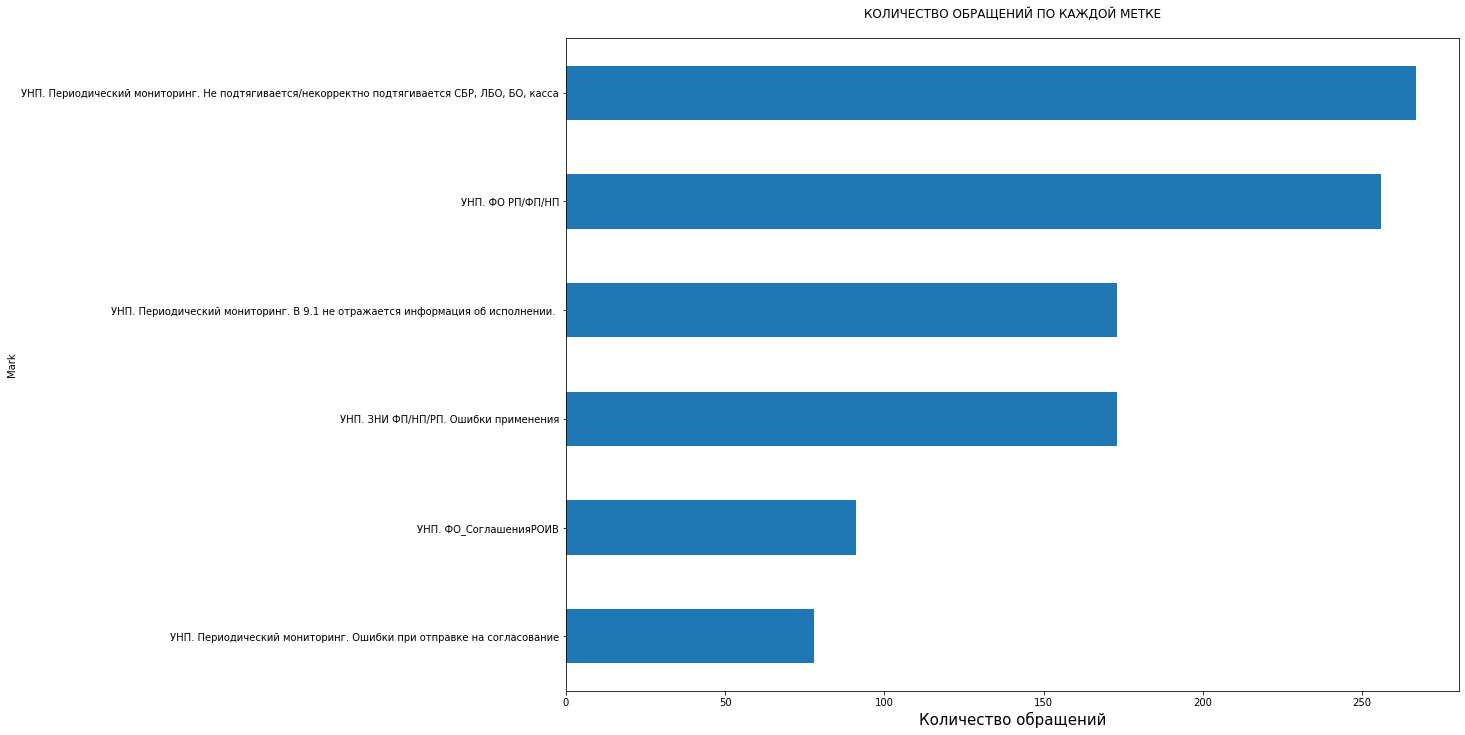

In [7]:
# Выводим диаграмму меток с колличеством обращений по каждой метке
fig = plt.figure(figsize=(16,12))
df1.groupby('Mark').Content.count().sort_values().plot.barh(
    ylim=0, title='КОЛИЧЕСТВО ОБРАЩЕНИЙ ПО КАЖДОЙ МЕТКЕ\n')
plt.xlabel('Количество обращений', fontsize = 15)
plt.savefig("marks.png")

In [8]:
# Инициализиуем список стоп слов, добавляем свои слова
stop_words = set(stopwords.words("russian"))
all_stop_words = (stop_words, "номер", "документ", "спасибо", "ожидать", "результат", "описание", "проблема", 
                  "скрин", "скриншот", "добрый", "день", "здравствуй", "уважаемый", "пользователь", "утро")

# Токенайзер, стеммер, лемматизатор
def tokenizer(doc):
    stem = Mystem()
    
    tokens = stem.lemmatize(doc)
    # стопслова
    tokens = [w.lower() for w in tokens if w not in all_stop_words]
    # знаки пунктуации
    tokens = [w for w in tokens if w not in string.punctuation]
    # слова
    tokens = [w for w in tokens if w.isalpha()]
    
    return tokens

# TfIdf векторайзер 
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        tokenizer=tokenizer, stop_words=stop_words)

# Преобразовываем каждый документ(обращение) в вектор
features = tfidf.fit_transform(df1.Content).toarray()

labels = df1.category_id

print("%d обращений используют %d признаков (значение TF-IDF для юниграм и биграм)" %features.shape)

C:\Users\a.bayburov\.conda\envs\Help_Desk_Folder\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'свой', 'это'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1038 обращений используют 2922 признаков (значение TF-IDF для юниграм и биграм)


In [9]:
# Поиск 3 наиболее коррелирующих юниграм и биграм для каждой из меток
N = 3
for Mark, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n%s:" %Mark)
  print("Юниграмы: %s" %(', '.join(unigrams[-N:])))
  print("Биграмы: %s" %(', '.join(bigrams[-N:])))


УНП. ЗНИ ФП/НП/РП. Ошибки применения:
Юниграмы: применять, запрос, применение
Биграмы: проект запрос, ошибка применение, запрос изменение

УНП. Периодический мониторинг. В 9.1 не отражается информация об исполнении. :
Юниграмы: пересохранять, статус, кт
Биграмы: исполнение кт, подтягиваться статус, статус исполнение

УНП. Периодический мониторинг. Не подтягивается/некорректно подтягивается СБР, ЛБО, БО, касса:
Юниграмы: лбо, перерасчет, кассовый
Биграмы: исполнение нажимать, актуальный данные, кассовый исполнение

УНП. Периодический мониторинг. Ошибки при отправке на согласование:
Юниграмы: показатель, согласование, отправка
Биграмы: исполнение показатель, согласование отчет, отправка согласование

УНП. ФО РП/ФП/НП:
Юниграмы: распределение, субъект, бюджет
Биграмы: вкладка бюджет, субъект распределение, бюджет субъект

УНП. ФО_СоглашенияРОИВ:
Юниграмы: продолжаться, мо, соглашение
Биграмы: справочный характер, исполнение столбец, подтягивание сумма


In [10]:
X = df1['Content']
y = df1['Mark']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [11]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Средняя точность', 'Стандартное отклонение']
acc

,Средняя точность,Стандартное отклонение
model_name,,
LinearSVC,0.774470,0.072232
LogisticRegression,0.788926,0.066704
MultinomialNB,0.764874,0.055129
RandomForestClassifier,0.756178,0.074390


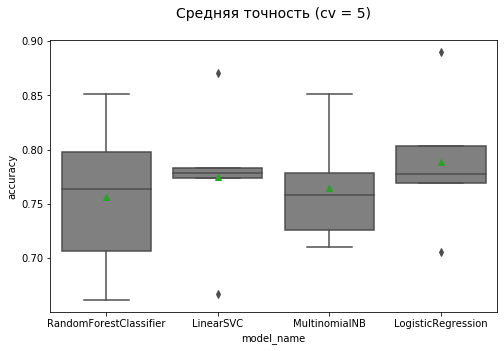

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='gray', 
            showmeans=True)
plt.title("Средняя точность (cv = 5)\n", size=14);

In [14]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df1.index, test_size=0.2, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [15]:
# Classification report
print('\t\t\t\tМЕТРИКИ КЛАССИФИКАЦИИ\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df1['Mark'].unique()))


				МЕТРИКИ КЛАССИФИКАЦИИ

                                                                                               precision    recall  f1-score   support

                                                                             УНП. ФО РП/ФП/НП       0.72      0.72      0.72        46
                                                         УНП. ЗНИ ФП/НП/РП. Ошибки применения       1.00      0.95      0.97        38
УНП. Периодический мониторинг. Не подтягивается/некорректно подтягивается СБР, ЛБО, БО, касса       0.81      0.83      0.82        58
                           УНП. Периодический мониторинг. Ошибки при отправке на согласование       0.71      0.62      0.67        16
                                                                       УНП. ФО_СоглашенияРОИВ       0.85      0.73      0.79        15
                УНП. Периодический мониторинг. В 9.1 не отражается информация об исполнении.        0.82      0.94      0.88        35

                          

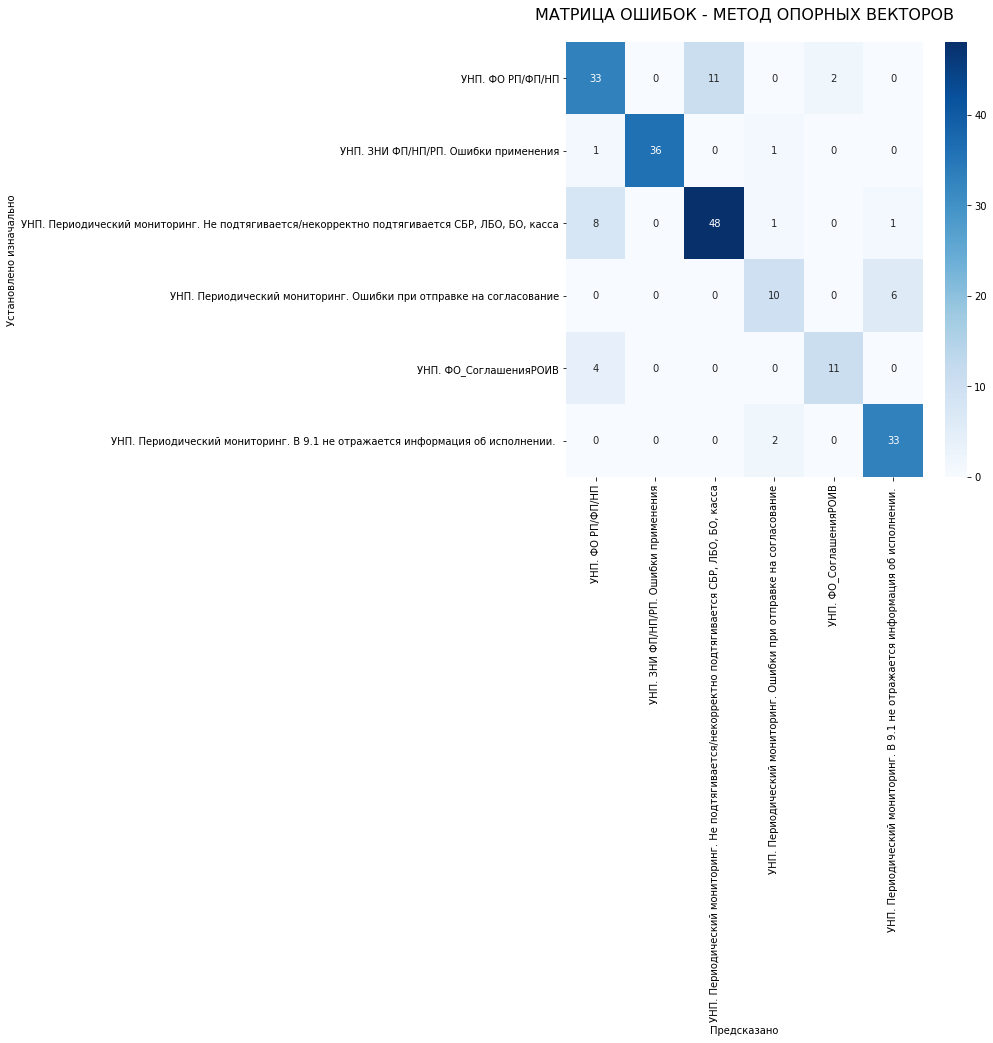

In [17]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Mark.values, 
            yticklabels=category_id_df.Mark.values)
plt.ylabel('Установлено изначально')
plt.xlabel('Предсказано')
plt.title("МАТРИЦА ОШИБОК - МЕТОД ОПОРНЫХ ВЕКТОРОВ\n", size=16)
plt.savefig("conf_matrix.png")

In [18]:
N = 4
for Mark, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n{}:".format(Mark))
  print("Самые частые юниграмы: %s" %(', '.join(unigrams)))
  print("Самые частые биграмы: %s" %(', '.join(bigrams)))


УНП. ЗНИ ФП/НП/РП. Ошибки применения:
Самые частые юниграмы: запрос, применять, изменение, зни
Самые частые биграмы: запрос изменение, ошибка применение, применение изменение, применять br

УНП. Периодический мониторинг. В 9.1 не отражается информация об исполнении. :
Самые частые юниграмы: кт, статус, мероприятие, точка
Самые частые биграмы: статус исполнение, сведение представлять, мониторинг br, подтягиваться статус

УНП. Периодический мониторинг. Не подтягивается/некорректно подтягивается СБР, ЛБО, БО, касса:
Самые частые юниграмы: епбс, кассовый, перерасчет, касса
Самые частые биграмы: кассовый исполнение, br кбк, актуальный данные, кнопка перерасчет

УНП. Периодический мониторинг. Ошибки при отправке на согласование:
Самые частые юниграмы: согласование, показатель, отчет, отправка
Самые частые биграмы: согласование реестр, год отчет, мониторинг код, согласование отчет

УНП. ФО РП/ФП/НП:
Самые частые юниграмы: бюджет, фо, нр, указывать
Самые частые биграмы: соглашение паспорт, ра

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        tokenizer=tokenizer, stop_words=stop_words)

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\a.bayburov\.conda\envs\Help_Desk_Folder\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\a.bayburov\.conda\envs\Help_Desk_Folder\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'свой', 'это'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [20]:
new_appeal = "Редакция 47.3.1. Данные в 5.ФО изменяются не корректно,значения столбца БР смещяются на год вперед.Не сохраняются изменения по столбцу сумма результата" \
                "Редакция 47.3.1. Данные в 5.ФО изменяются не корректно,значения столбца БР смещяются на год вперед.Не сохраняются изменения по столбцу сумма результата."
print(model.predict(fitted_vectorizer.transform([new_appeal])))

['УНП. ФО РП/ФП/НП']
